In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score as rs
from sklearn.model_selection import GridSearchCV
import graphviz as gv
from IPython.display import Image

%matplotlib inline

In [2]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

---
## Question 2: Build a tree by hand following exactly the lecture notes. 

# Solutions from Cheng Hou.

In [3]:
data2='MPG, cylinders, HP, weight\ngood, 4, 75, light\nbad, 6, 90, medium\nbad, 4, 110, medium\nbad, 8, 175, weighty\nbad, 6, 95, medium\nbad, 4, 94, light\nbad, 4, 95, light\nbad, 8, 139, weighty\nbad, 8, 190, weighty\nbad, 8, 145, weighty\nbad, 6, 100, medium\ngood, 4, 92, medium\nbad, 6, 100, weighty\nbad, 8, 170, weighty\ngood, 4, 89, medium\ngood, 4, 65, light\nbad, 6, 85, medium\ngood, 4, 81, light\nbad, 6, 95, medium\ngood, 4, 93, light'

In [4]:
data2=",".join(data2.split(", "))
print data2

MPG,cylinders,HP,weight
good,4,75,light
bad,6,90,medium
bad,4,110,medium
bad,8,175,weighty
bad,6,95,medium
bad,4,94,light
bad,4,95,light
bad,8,139,weighty
bad,8,190,weighty
bad,8,145,weighty
bad,6,100,medium
good,4,92,medium
bad,6,100,weighty
bad,8,170,weighty
good,4,89,medium
good,4,65,light
bad,6,85,medium
good,4,81,light
bad,6,95,medium
good,4,93,light


### a) Prepare the data set to a pandas dataframe from the given string

In [5]:
def Str2df(data):
    datalines = data.splitlines()
    df = pd.DataFrame()
    for i,l in enumerate(datalines):
        if i == 0:
            columns_ = datalines[0].split(",")
            continue
        df = df.append([datalines[i].split(",")], ignore_index=True)
    df.columns = columns_
    return df

In [6]:
df2 = Str2df(data2)
df2

,MPG,cylinders,HP,weight
0,good,4,75,light
1,bad,6,90,medium
2,bad,4,110,medium
3,bad,8,175,weighty
4,bad,6,95,medium
5,bad,4,94,light
6,bad,4,95,light
7,bad,8,139,weighty
8,bad,8,190,weighty
9,bad,8,145,weighty


### b) Start with the entire dataset and find the most common value

In [7]:
df2.describe()

,MPG,cylinders,HP,weight
count,20,20,20,20
unique,2,3,17,3
top,bad,4,95,medium
freq,14,9,3,8


The most common value is "**bad**" from column ***MPG***

### c) Use "information gain" as your decision rule to split your data into two groups. What is the split rule and what is the maximum value of the information gain? 

In [8]:
def Gain(A, B, C, D):
    def F(X,Y):
        if (X != 0) & (Y != 0):
            return X*np.log2(1.*(X+Y)/X) + Y*np.log2(1.*(X+Y)/Y)
        elif (X == 0) & (Y == 0):
            return 0
        elif X == 0:
            return Y*np.log2(1.*(X+Y)/Y)
        elif Y == 0:
            return X*np.log2(1.*(X+Y)/X)
    
    return (F(A+C,B+D)-F(A,B)-F(C,D)) / (A+B+C+D)

In [9]:
def Getrealuvs(df, tc, sc):
    def Generatordf(df, tc, sc):
        sortlist = globals()[df].sort_values(by=sc).loc[:,[sc,tc]].reset_index(drop=True)
        for i in range(len(sortlist)):
            yield sortlist.ix[i]
    
    diff = ''
    v = 0
    uvs = []
    for row in Generatordf(df, tc, sc):
        if diff == '':
            diff = row[tc]
            v = row[sc]
            continue
        elif row[tc] == diff:
            v = row[sc]
            continue
        else:
            uvs.append((v+row[sc]) / 2)
            v = row[sc]
            continue
    return uvs

In [10]:
def SplitTry(df, tc, sc, real, P, N, printout=False):
    if not real:
        uvs = globals()[df][sc].unique()
        Gains = []
        for uv in uvs:
            A = np.sum((globals()[df][sc] == uv) & (globals()[df][tc] == P))
            B = np.sum((globals()[df][sc] == uv) & (globals()[df][tc] == N))
            C = np.sum((globals()[df][sc] != uv) & (globals()[df][tc] == P))
            D = np.sum((globals()[df][sc] != uv) & (globals()[df][tc] == N))
            Gains.append(Gain(A, B, C, D))
            if printout:
                print("{}  {:2}+/{:2}-  {:2}+/{:2}-  {:4.3f}".format("{} = {}".format(sc,uv).center(16),
                                                                     A, B, C, D, Gains[-1]))
        
        return uvs, Gains
    
    else:
        uvs = Getrealuvs(df, tc, sc)
        Gains = []
        for uv in uvs:
            A = np.sum((globals()[df][sc] > uv) & (globals()[df][tc] == P))
            B = np.sum((globals()[df][sc] > uv) & (globals()[df][tc] == N))
            C = np.sum((globals()[df][sc] <= uv) & (globals()[df][tc] == P))
            D = np.sum((globals()[df][sc] <= uv) & (globals()[df][tc] == N))
            Gains.append(Gain(A, B, C, D))
            if printout:
                print("{}  {:2}+/{:2}-  {:2}+/{:2}-  {:4.3f}".format("{} > {}".format(sc,uv).center(16),
                                                                     A, B, C, D, Gains[-1]))
        
        return uvs, Gains

In [11]:
def SplitStep(df, tc, sc, real, P, N, printout=False):
    if printout:
        print("{}  {}  {}  {}\n{}".format('Split'.center(16),'Group Y', 'Group N', 'Gain', '-'*42))
        
    Rules = []
    for c,r in zip(sc, real):
        uvs, Gains = SplitTry(df, tc, c, r, P, N, printout=printout)
        maxi = np.argmax(Gains)
        if r:
            Rules.append([c, '>', uvs[maxi], Gains[maxi]])
        else:
            Rules.append([c, '=', uvs[maxi], Gains[maxi]])
    
    maxi = np.argmax(map(lambda x: x[-1], Rules))
    if printout:
        print('-'*42)
        print(" + represent {} = {}".format(tc, P))
        print(" - represent {} = {}".format(tc, N))
        print("\nBest Split Rule : {} {} {}".format(Rules[maxi][0],Rules[maxi][1],Rules[maxi][2]))
        print("Information Gain = {}".format(Rules[maxi][3]))
    
    return Rules[maxi]

In [12]:
df2.HP = df2.HP.astype(float)

In [13]:
SplitStep('df2','MPG',['HP','cylinders','weight'],[True,False,False],'good','bad',printout=True)

     Split        Group Y  Group N  Gain
------------------------------------------
   HP > 83.0       3+/14-   3+/ 0-  0.310
   HP > 89.5       2+/13-   4+/ 1-  0.276
   HP > 93.5       0+/12-   6+/ 2-  0.557
   HP > 94.5       0+/11-   6+/ 3-  0.468
   HP > 95.0       0+/ 8-   6+/ 6-  0.281
   HP > 95.0       0+/ 8-   6+/ 6-  0.281
   HP > 97.5       0+/ 8-   6+/ 6-  0.281
   HP > 100.0      0+/ 6-   6+/ 8-  0.192
   HP > 105.0      0+/ 6-   6+/ 8-  0.192
   HP > 124.5      0+/ 5-   6+/ 9-  0.153
   HP > 142.0      0+/ 4-   6+/10-  0.118
   HP > 157.5      0+/ 3-   6+/11-  0.085
   HP > 172.5      0+/ 2-   6+/12-  0.055
   HP > 182.5      0+/ 1-   6+/13-  0.027
 cylinders = 4     6+/ 3-   0+/11-  0.468
 cylinders = 6     0+/ 6-   6+/ 8-  0.192
 cylinders = 8     0+/ 5-   6+/ 9-  0.153
 weight = light    4+/ 2-   2+/12-  0.192
weight = medium    2+/ 6-   4+/ 8-  0.006
weight = weighty   0+/ 6-   6+/ 8-  0.192
------------------------------------------
 + represent MPG = good
 - repres

['HP', '>', 93.5, 0.5567796494470395]

### d) Repeat the process b) and c) until that you can perfectly split the training data. Show the resulting decision tree in a format of your choice, as long as the tree structure and the prediction at each leaf node are clearly shown. 

In [14]:
def DTree(Idx = None):
    t = {'Y' : None,
         'N' : None,
         'Rule' : None,
         'indicator' : None,
         'nodes' : Idx}
    return t

In [15]:
def SplitAll(df, tc, sc, real, printout=False, printdetail=False):
    dff = 'Splitdf'
    Idx = globals()[df].index.values
    loop = True
    [P,N] = globals()[df][tc].unique()
    
    def Cal(Idx):
        DT = DTree(Idx)
        globals()[dff] = globals()[df].ix[Idx]
        if len(globals()[dff][tc].unique()) == 1:
            DT['indicator'] = globals()[dff][tc].unique()[0]
            return DT
        else:
            DT['Rule'] = SplitStep(dff, tc, sc, real, P, N)
            if DT['Rule'][1] == '=':
                YIdx = filter(lambda i: globals()[dff][DT['Rule'][0]][i] == DT['Rule'][2], Idx)
            else:
                YIdx = filter(lambda i: globals()[dff][DT['Rule'][0]][i] > DT['Rule'][2], Idx)
            NIdx = filter(lambda x:x not in YIdx, Idx)
            DT['Y'] = Cal(YIdx)
            DT['N'] = Cal(NIdx)
            return DT
        
    DT = Cal(Idx)    
                
    del globals()[dff]
    return DT

In [48]:
def DTPlot(DT, filename='Decision_Tree_ch3019'):
    G = gv.Graph(format='png')
    
    def AddTree(DT, name='R'):
        if DT['indicator'] != None:
            G.node(name, label=DT['indicator'])
            G.edge(name[:-1], name, label=name[-1])
        else:
            G.node(name, label = reduce(lambda x,y: str(x)+' '+str(y), DT['Rule'][:-1])+' ?')
            if name != 'R':
                G.edge(name[:-1], name, label=name[-1])
            AddTree(DT['Y'], name+'Y')
            AddTree(DT['N'], name+'N')
            
    AddTree(DT)
    f = G.render(filename=filename)
    return f

In [36]:
DT = SplitAll('df2','MPG',['HP','cylinders','weight'],[True,False,False])
DT

{'N': {'N': {'N': None,
   'Rule': None,
   'Y': None,
   'indicator': 'bad',
   'nodes': [1, 16]},
  'Rule': ['cylinders', '=', '4', 0.81127812445913283],
  'Y': {'N': None,
   'Rule': None,
   'Y': None,
   'indicator': 'good',
   'nodes': [0, 11, 14, 15, 17, 19]},
  'indicator': None,
  'nodes': [0, 1, 11, 14, 15, 16, 17, 19]},
 'Rule': ['HP', '>', 93.5, 0.5567796494470395],
 'Y': {'N': None,
  'Rule': None,
  'Y': None,
  'indicator': 'bad',
  'nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 18]},
 'indicator': None,
 'nodes': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19])}

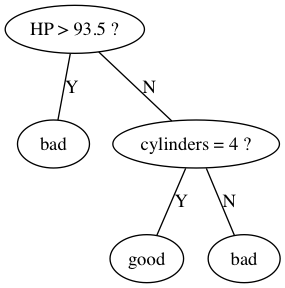

In [49]:
Image(DTPlot(DT))

### f) Classify the following five vehicles as having "good" or "bad" fuel efficiency (miles per gallon). You can do this by hand using the tree structure learned in part d), or automatically using the function you wrote in part e).

In [24]:
data2_test = "?,4,93,weighty ?,8,70,light ?,6,113,medium ?,6,95,weighty ?,4,115,medium"
data2_test = "\n".join(data2_test.split(" "))
print data2_test

?,4,93,weighty
?,8,70,light
?,6,113,medium
?,6,95,weighty
?,4,115,medium


In [25]:
data2_train = "\n".join(data2.splitlines()[1:])
print data2_train

good,4,75,light
bad,6,90,medium
bad,4,110,medium
bad,8,175,weighty
bad,6,95,medium
bad,4,94,light
bad,4,95,light
bad,8,139,weighty
bad,8,190,weighty
bad,8,145,weighty
bad,6,100,medium
good,4,92,medium
bad,6,100,weighty
bad,8,170,weighty
good,4,89,medium
good,4,65,light
bad,6,85,medium
good,4,81,light
bad,6,95,medium
good,4,93,light


In [26]:
print Tree(data2_train, data2_test)

good,4,93.0,weighty
bad,8,70.0,light
bad,6,113.0,medium
bad,6,95.0,weighty
bad,4,115.0,medium


---
## Question 3, Predicting burden of disease
### Your goal is to train a decision tree classifier for the attribute “BurdenOfDisease" using all other variables (except country name) as features using sklearn.tree.DecisionTreeClassifier. 

In [27]:
data=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/Burden of diarrheal illness by country.csv")
print("Here are the first three rows:")
data.iloc[0:3,:]

Here are the first three rows:


,Country,FrxnPeaceIn10,ODA4H2OPcptaDol,RenewResm3PcptaYr,SustAccImprWatRur,SustAccImprWatUrb,SustAccImprSanRur,SustAccImprSanUrb,TotHlthExpPctofGDP,GenGovtPctofTotHlthExp,ExtResHlthPctTotExpHlth,PCptaGovtExpHlthAvgExcRt,GDPPCptaIntDol,AdultLtrcyRate,FemaleLtrcyRate,BurdenOfDisease
0,Afghanistan,0.1,0.16,2986,0.10891,0.18812,0.049505,0.15842,0.065,0.395,0.4560,4,430,0.35644,0.20792,awful
1,Albania,1.0,5.58,13306,0.94059,0.98020,0.801980,0.98020,0.065,0.417,0.0340,49,6158,0.85644,0.78713,low
2,Algeria,0.0,0.33,473,0.79208,0.91089,0.811880,0.98020,0.041,0.808,0.0005,71,4860,0.69307,0.60396,high


### a) Please choose a test/train split and choose a hyper-parameter governing model simplicity. For example, the maximum tree depth or maximum number of leaf nodes. Then, fit your decision tree classifier for different values of this parameter and for each such value, record the corresponding AUC score.

In [28]:
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

In [29]:
def AvgAUC(y_test, proba, classes):
    AUC = []
    for i,c in enumerate(classes):
        real = (y_test == c)
        AUC.append(rs(real, proba[:,i]))
    return np.mean(AUC)

In [31]:
AUC = []

for i in range(2,100,3):    
    dt = DTC(max_leaf_nodes=i)
    dt.fit(X_train, y_train)
    AUC.append(AvgAUC(y_test, dt.predict_proba(X_test), dt.classes_))

### b) Make a plot of performance vs. simplicity for different values of the hyper-parameter chosen in part a). That is, the x-axis should be hyper-parameter value (e.g. tree depth) and the y-axis should be AUC score.

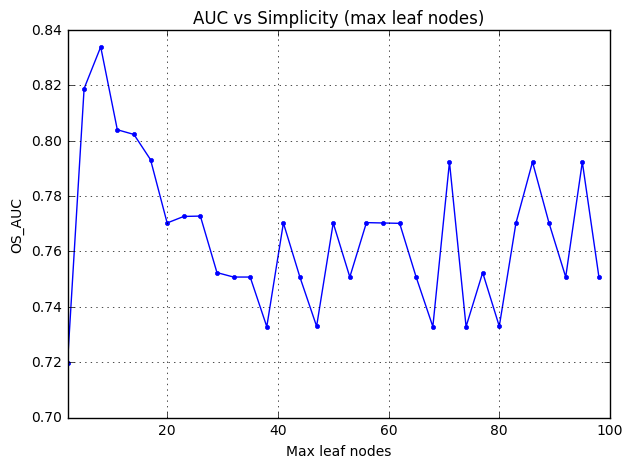

In [32]:
plt.figure(figsize=(7,5))
plt.plot(range(2,100,3), AUC, '.-')
plt.xlabel("Max leaf nodes")
plt.ylabel("OS_AUC")
plt.title("AUC vs Simplicity (max leaf nodes)")
plt.xlim(2,100)
plt.grid(True)
plt.show()

### c) Tune the hyper-parameter you choose in part a) by cross-validation using the training data. You can choose to use package from sklearn or write your own code to do cross-validation by spliting the training data into training and validation data. What is the OS accuracy after tuning the hyper-parameter?

In [33]:
OS_dtc = []
param_grid_dtc ={'max_leaf_nodes': range(2,100,3)}
for i in range(20):
    X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.3, random_state=i)
    dtc = DTC()
    gsdtc = GridSearchCV(dtc, param_grid=param_grid_dtc)
    gsdtc.fit(X_tr, y_tr)
    OS_dtc.append(gsdtc.score(X_test, y_test))
    
print np.mean(OS_dtc)

0.65


### d) Visualize a simple decision tree (e.g. a “shallow” tree, or a tree with few leaf nodes) classifier and report its performance. You can draw the decision tree by hand or use a graphical representation (e.g. http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html), but make sure it is easy to understand (e.g. the features chosen for each split should be clearly labeled in each internal node, as well as the prediction at each leaf node).

In [41]:
X_train_simple = X_train.iloc[:,[0,1,2]]
X_test_simple = X_test.iloc[:,[0,1,2]]
dtc = DTC(max_leaf_nodes=10)
dtc.fit(X_train_simple, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

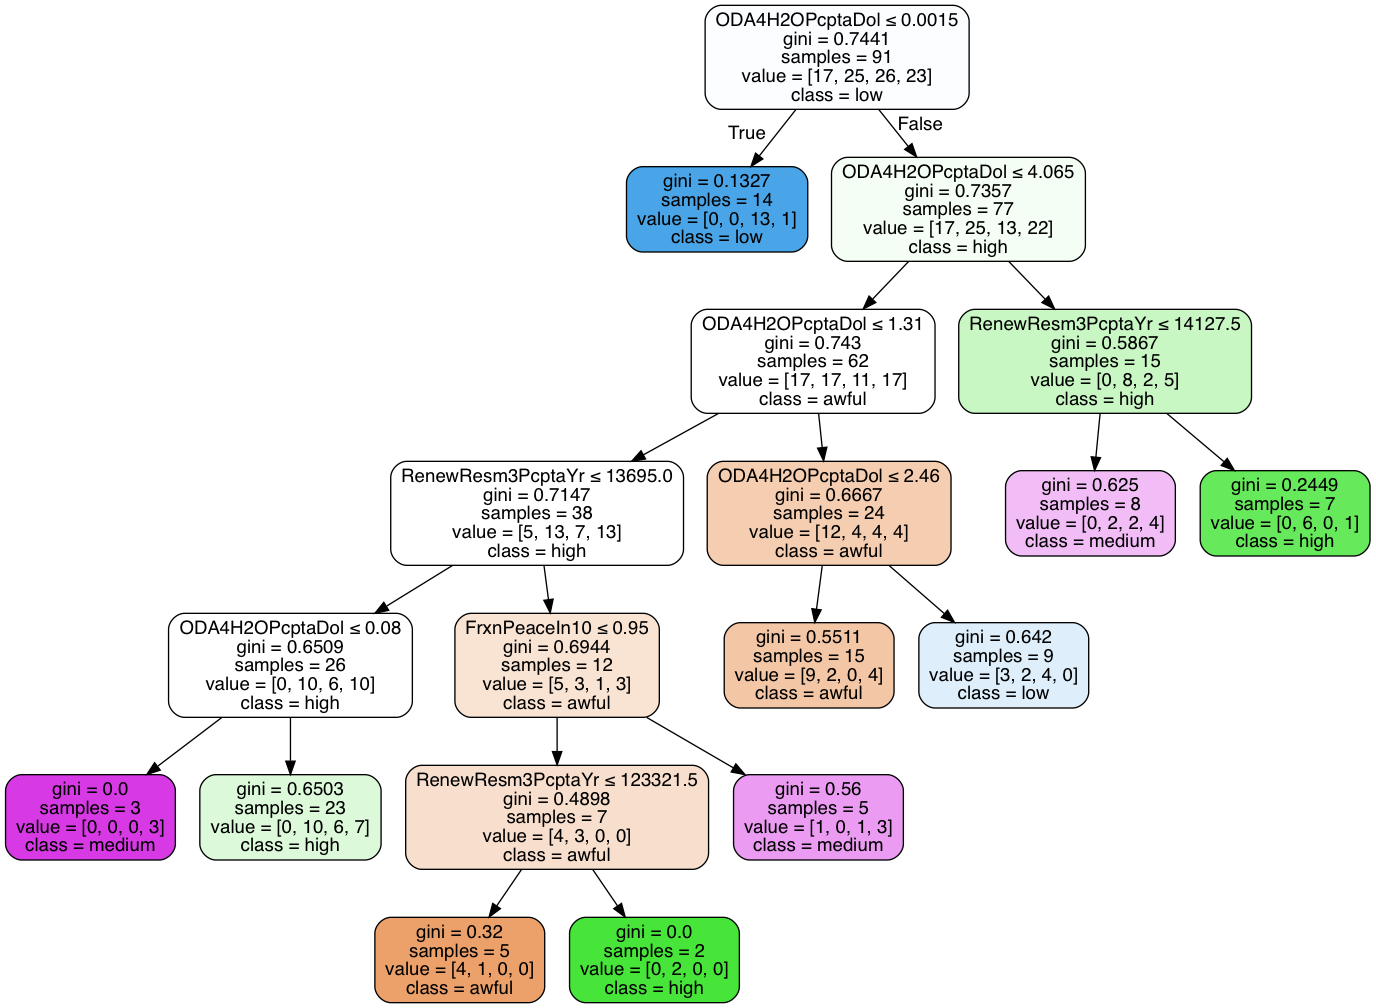

In [47]:
from sklearn.externals.six import StringIO as SIO
from sklearn import tree
import pydotplus
dot_data = SIO()  
tree.export_graphviz(dtc, out_file=dot_data,  
                         feature_names=X_train_simple.columns.values,  
                         class_names=dtc.classes_,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

## Question 4. 

## Solutions from Xinshi Zheng



In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = data.loc[:, 'FrxnPeaceIn10':'FemaleLtrcyRate']
Y = data.loc[:, 'BurdenOfDisease']

X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=1)

score_dic = {}
for i in range(1,20):
    clf = RandomForestClassifier(max_depth=i, random_state=1)
    score_dic[i] = cross_val_score(clf, X_train, Y_train, scoring='accuracy', cv=5)

avgScore_dict = {}
for k, v in score_dic.iteritems():
    avgScore_dict[k] = np.mean(v)
    print k, avgScore_dict[k]